In [9]:
import torch
import data_s2s
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import pdb

snapshot_scratch = '/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-04-24_22-09-30/snapshot_240000.pt'
snapshot_ft = '/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-04-25_13-39-51/snapshot_2180000.pt'
r3m_scratch = load_r3m('resnet50', snapshot_scratch).to('cuda:0')
r3m_scratch.eval()
r3m_ft = load_r3m('resnet50', snapshot_ft).to('cuda:0')
r3m_ft.eval()


/home/ademi_adeniji/anaconda3/envs/r3m_base/lib/python3.9/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoi

DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [10]:
def show_images(batch: torch.Tensor, size=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    images = Image.fromarray(reshaped.numpy())
    if size is not None:
        images = images.resize(size, Image.NEAREST)
    display(images)

def show_images_rlbench(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)
    

video id: 66903


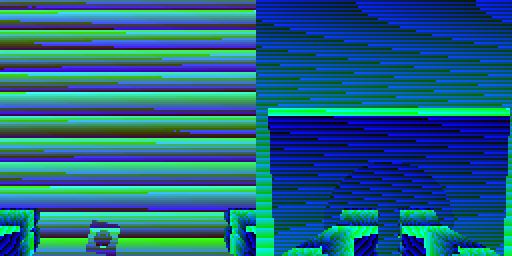

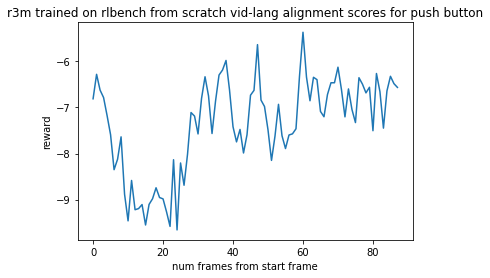

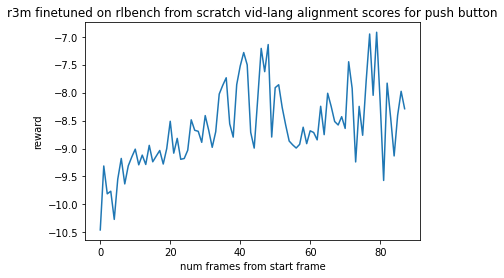

In [47]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

datapath = '/shared/mandi/all_rlbench_data'
manifest = pd.read_csv(f"{datapath}manifest.csv")
datalen = len(manifest)
vidid = np.random.randint(0, datalen)
vidid = 66903
print(f"video id: {vidid}")
m = manifest.iloc[vidid]
vidlen = m["len"] - 1
txt = m["txt"]
label = txt.replace("_", " ")
lang = np.array([label])
vid = m["path"]
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
start_image = torchvision.io.read_image(f"{vid}/{0}.png")
end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.png")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start)
start_ft = r3m_ft(start)
rewards_scratch = []
rewards_ft = []
for index in range(vidlen):
    end = torchvision.io.read_image(f"{vid}/{index}.png")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end)
    end_ft = r3m_ft(end)
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_ft.append(r3m_ft.module.get_reward(start_ft, end_ft, lang)[0].cpu().detach())
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
plt.plot(rewards_scratch)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m trained on rlbench from scratch vid-lang alignment scores for " + label)
plt.show(); plt.clf()
plt.plot(rewards_ft)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m finetuned on rlbench from scratch vid-lang alignment scores for " + label)
plt.show()

video id: 66903


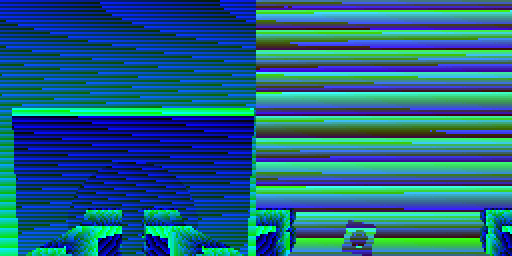

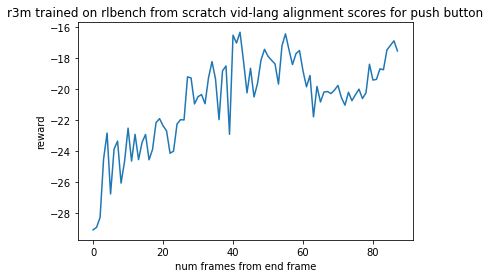

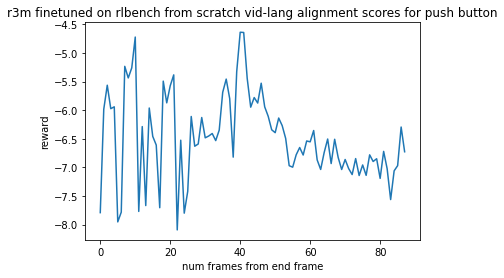

In [48]:
start = resize((end_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start)
start_ft = r3m_ft(start)
rewards_scratch = []
rewards_ft = []
for index in reversed(range(vidlen)):
    end = torchvision.io.read_image(f"{vid}/{index}.png")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end)
    end_ft = r3m_ft(end)
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_ft.append(r3m_ft.module.get_reward(start_ft, end_ft, lang)[0].cpu().detach())
print(f"video id: {vidid}")
show_images_rlbench(torch.stack([end_image, start_image]), size=(512, 256))
plt.plot(rewards_scratch)
plt.xlabel("num frames from end frame")
plt.ylabel("reward")
plt.title("r3m trained on rlbench from scratch vid-lang alignment scores for " + label)
plt.show(); plt.clf()
plt.plot(rewards_ft)
plt.xlabel("num frames from end frame")
plt.ylabel("reward")
plt.title("r3m finetuned on rlbench from scratch vid-lang alignment scores for " + label)
plt.show()